In [1]:
import torch
from torchvision import datasets, models, transforms
import torchvision
import torch.nn as nn
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [3]:
train_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [4]:
zip = zipfile.ZipFile("datasets/flowers_.zip")
zip.extractall("datasets")

In [5]:
data_dir = "datasets/flowers_"

In [6]:
image_datasets = {}

In [7]:
image_datasets["train"] = datasets.ImageFolder(data_dir + "/train", train_transform)

In [8]:
image_datasets["test"] = datasets.ImageFolder(data_dir + "/test", test_transform)

In [9]:
print("Training data size - %d" % len(image_datasets["train"]))
print("Test data size - %d" % len(image_datasets["test"]))

Training data size - 3027
Test data size - 1296


In [10]:
class_names = image_datasets["train"].classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [11]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 3027
     Root location: datasets/flowers_/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1296
     Root location: datasets/flowers_/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [12]:
dataloaders = {}

In [13]:
dataloaders["train"] = torch.utils.data.DataLoader(
    image_datasets["train"], batch_size=8, shuffle=True, num_workers=4
)

In [14]:
dataloaders["test"] = torch.utils.data.DataLoader(
    image_datasets["test"], batch_size=8, shuffle=True, num_workers=4
)

In [15]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x23426029690>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x23426029660>}

In [16]:
inputs, labels = next(iter(dataloaders["train"]))

In [17]:
inputs.shape

torch.Size([8, 3, 224, 224])

In [18]:
labels

tensor([0, 3, 1, 4, 3, 2, 2, 1])

In [19]:
inp = torchvision.utils.make_grid(inputs)
inp.shape

torch.Size([3, 228, 1810])

In [20]:
inp.max()

tensor(2.6400)

In [21]:
np.clip(inp, 0, 1).max()

tensor(1.)

In [22]:
inp.numpy().transpose((1, 2, 0)).shape

(228, 1810, 3)

In [23]:
plt.ion()

In [24]:
def img_show(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(16, 4))
    plt.axis("off")
    plt.imshow(inp)

    if title is not None:
        plt.title(title)

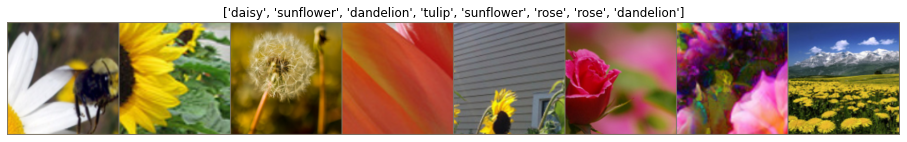

In [25]:
img_show(inp, title=[class_names[x] for x in labels])

In [26]:
model = models.resnet18(weights="DEFAULT")

In [27]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [28]:
model.fc = nn.Linear(num_ftrs, 5)

In [29]:
criterion = nn.CrossEntropyLoss()

In [30]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [31]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [32]:
def calculate_accuracy(phase, running_loss, running_corrects):
    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])
    print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
    return (epoch_loss, epoch_acc)

In [33]:
def phase_train(model, criterion, optimizer, scheduler):
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders["train"]:
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    calculate_accuracy("train", running_loss, running_corrects)

In [34]:
best_acc = 0.0

In [35]:
def phase_test(model, criterion, optimizer):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    global best_acc

    for inputs, labels in dataloaders["test"]:
        optimizer.zero_grad()
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss, epoch_acc = calculate_accuracy("test", running_loss, running_corrects)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    return best_model_wts

In [36]:
def build_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        phase_train(model, criterion, optimizer, scheduler)
        best_model_wts = phase_test(model, criterion, optimizer)
        print()

    print("Best test Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [37]:
model = build_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------


C:\Users\natha\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.7086 Acc: 0.7380
test Loss: 0.4204 Acc: 0.8573

Best test Acc: 0.857253


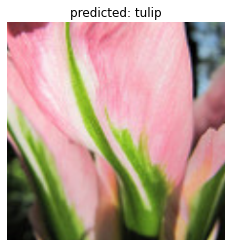

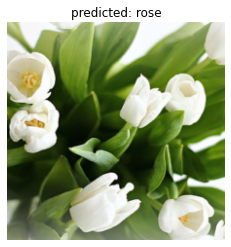

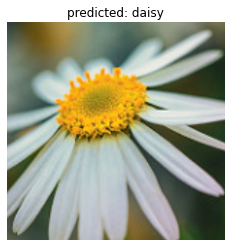

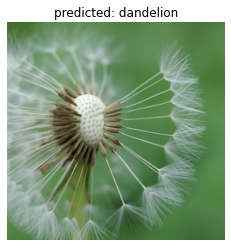

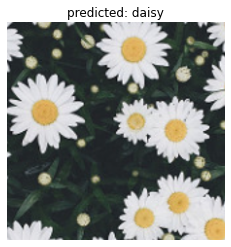

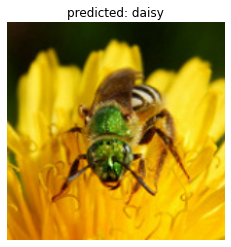

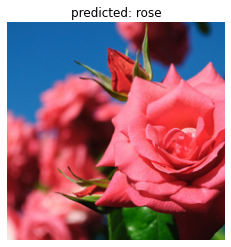

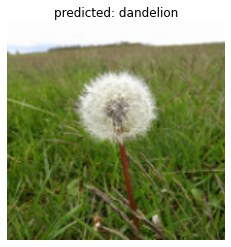

In [38]:
with torch.no_grad():
    inputs, labels = iter(dataloaders["test"]).next()
    inp = torchvision.utils.make_grid(inputs)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    for j in range(len(inputs)):
        inp = inputs.data[j]
        img_show(inp, "predicted: " + class_names[preds[j]])

In [39]:
frozen_model = models.resnet18(weights="DEFAULT")

In [40]:
for param in frozen_model.parameters():
    param.requires_grad = False

In [41]:
frozen_model.fc = nn.Linear(num_ftrs, 5)

In [42]:
optimizer = optim.SGD(frozen_model.fc.parameters(), lr=0.001, momentum=0.9)

In [43]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [44]:
criterion = nn.CrossEntropyLoss()

In [45]:
best_acc = 0.0

In [46]:
frozen_model = build_model(
    frozen_model, criterion, optimizer, exp_lr_scheduler, num_epochs=1
)

Epoch 0/0
----------
train Loss: 0.8542 Acc: 0.6819
test Loss: 0.5765 Acc: 0.7847

Best test Acc: 0.784722


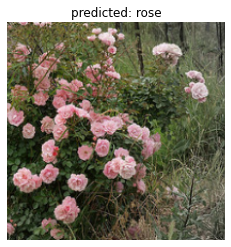

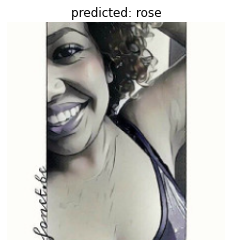

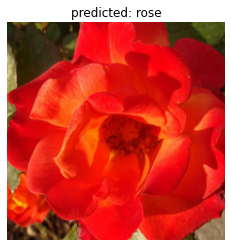

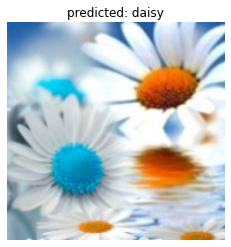

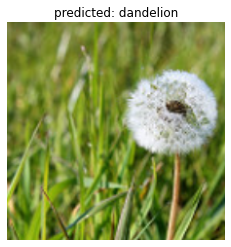

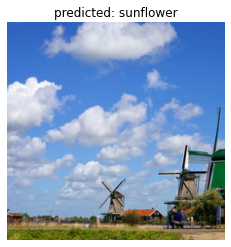

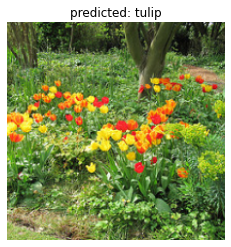

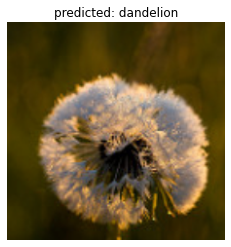

In [47]:
with torch.no_grad():
    inputs, labels = iter(dataloaders["test"]).next()
    inp = torchvision.utils.make_grid(inputs)

    outputs = frozen_model(inputs)
    _, preds = torch.max(outputs, 1)

    for j in range(len(inputs)):
        inp = inputs.data[j]
        img_show(inp, "predicted: " + class_names[preds[j]])